About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake news
           0: real News





Importing the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# printing the stopwords in English
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c fake-news

In [ ]:
# Extracting the compressed dataset
from zipfile import ZipFile
dataset = '/content/fake-news.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


Data Pre-processing

In [ ]:
# loading the dataset to a pandas DataFrame
news_dataset = pd.read_csv('/content/train.csv')

In [ ]:
news_dataset.shape

(20800, 5)

In [ ]:
# print the first 5 rows of the dataframe
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [ ]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

In [ ]:
# merging the author name and news title
news_dataset['content'] = news_dataset['author']+' '+news_dataset['title']

In [ ]:
news_dataset.head(5)

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [ ]:
print(news_dataset['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [ ]:
# separating the data & label
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [53]:
# print(X)
# print(Y)

Stemming:

Stemming is the process of reducing a word to its Root word

example:
actor, actress, acting --> act

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
news_dataset['content'] = news_dataset['content'].apply(stemming)

In [ ]:
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [ ]:
#separating the data and label
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [ ]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [ ]:
print(Y)

[1 0 1 ... 0 1 1]


In [ ]:
Y.shape

(20800,)

In [ ]:
X.shape

(20800,)

In [ ]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [52]:
# print(X)

In [ ]:
X.shape

(20800, 17128)

Splitting the dataset to training & test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

Training the Model: Logistic Regression

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
# Building pipelins.

dt=DecisionTreeClassifier()

rf=RandomForestClassifier()

knn=KNeighborsClassifier()

lr = LogisticRegression()

svc = SVC()




# List of the models
models = [dt, rf, knn, lr, svc]

# Pipeliline model names
model_dict = {0: "DecisionTree", 1: "RandomForest",2: "KNeighbors", 3: "Logistic Regression", 4: "Support vector"}


In [ ]:
acc_train = []
acc_test = []
for i, model in enumerate(models):
    model.fit(x_train, y_train)
    accuracy_train = model.score(x_train,y_train)
    accuracy_test = model.score(x_test,y_test)
    acc_train.append(accuracy_train*100)
    acc_test.append(accuracy_test*100)
    print(f"{model_dict[i]}:\nTraining --->  {accuracy_train * 100}%")
    print(f"For test --->  {accuracy_test * 100}%\n")

DecisionTree:
Training --->  100.0%
For test --->  99.23076923076923%

RandomForest:
Training --->  100.0%
For test --->  99.20673076923077%

KNeighbors:
Training --->  53.605769230769226%
For test --->  52.33173076923077%

Logistic Regression:
Training --->  98.6358173076923%
For test --->  97.90865384615385%

Support vector:
Training --->  99.90985576923077%
For test --->  98.89423076923077%



In [ ]:
import matplotlib.pyplot as plt

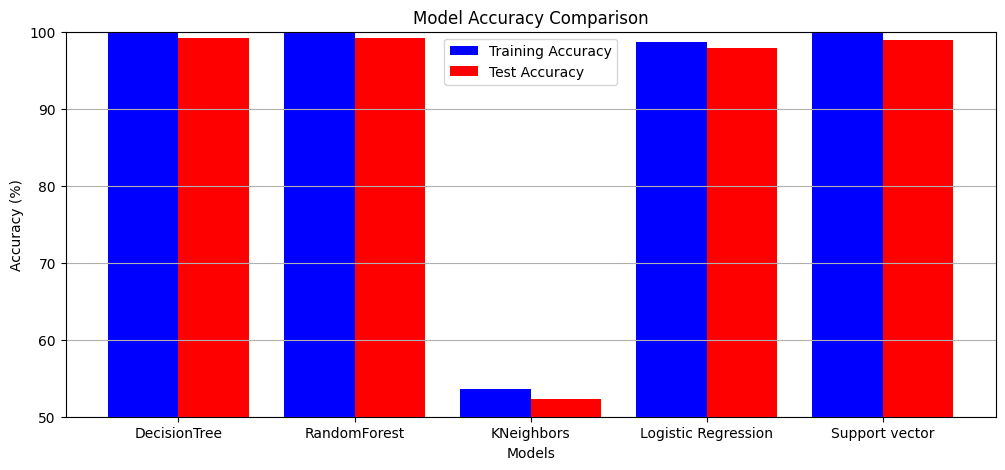

In [ ]:
x = range(len(model_dict))
plt.figure(figsize=(12,5))
plt.bar(x, acc_train, width=0.4, label='Training Accuracy', color='b', align='center')
plt.bar([p + 0.4 for p in x], acc_test, width=0.4, label='Test Accuracy', color='r', align='center')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xticks([p + 0.2 for p in x], list(model_dict.values()))
plt.grid(axis = 'y')
plt.ylim(50, 100)
plt.legend()
plt.show()

Random Forest is best

Making a Predictive System

In [ ]:
import pickle

In [ ]:
filename = 'fake_news.sav'
pickle.dump(rf,open(filename,'wb'))

In [51]:
filename = 'vector.sav'
pickle.dump(vectorizer,open(filename,'wb'))

In [ ]:
loaded_model = pickle.load(open('fake_news.sav', 'rb'))

In [ ]:
X_new = x_test[3]

prediction = loaded_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real
